## Condensation of this modules code

In [13]:
import torch
from torch import nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "CPU"
torch.__version__, device



('2.4.1+cu124', 'cuda')

## Data

In [14]:
# y = aX + b

weight = 0.2
bias = 0.8

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

print("X = ", X[:10], "\n\n","y = ", y[:10])

X =  tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]]) 

 y =  tensor([[0.8000],
        [0.8040],
        [0.8080],
        [0.8120],
        [0.8160],
        [0.8200],
        [0.8240],
        [0.8280],
        [0.8320],
        [0.8360]])


In [15]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

print(len(X_train), len(y_train), len(X_test), len(y_test))

40 40 10 10


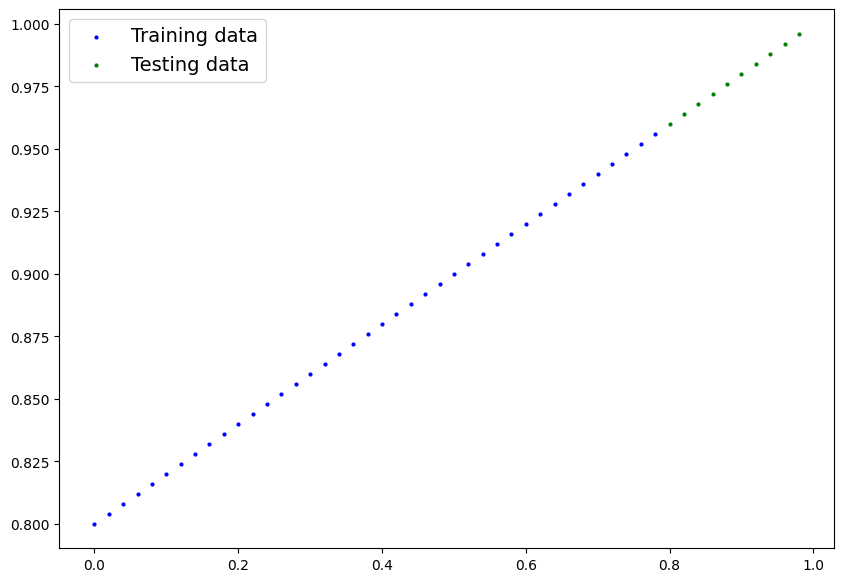

In [16]:
def plot_predictions(
    train_data = X_train.cpu(),
    train_labels = y_train.cpu(),
    test_data = X_test.cpu(),
    test_labels = y_test.cpu(),
    predictions = None
):
    """
    Plots training data, tests data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    
    # training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    # test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
    
    if predictions is not None:
        # plot the prtedictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # Show the legend
    plt.legend(prop={"size": 14})
    
plot_predictions()

## Building a linear model

In [17]:
# Create a linear model by subclassing nn.Module


class LinearRegressionModelV2(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
    
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## Training Model

In [18]:
# check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [19]:
# set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [20]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.001)
torch.cuda.manual_seed(42)
torch.manual_seed(42)

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 10001

for epoch in range(epochs):
    model_1.train()
    
    y_pred = model_1(X_train)
    
    loss = loss_fn(y_pred, y_train)
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
    


Epoch: 0 | Loss: 0.25017794966697693 | Test loss: 0.5311000943183899
Epoch: 10 | Loss: 0.23865707218647003 | Test loss: 0.5176293253898621
Epoch: 20 | Loss: 0.22713623940944672 | Test loss: 0.5041584968566895
Epoch: 30 | Loss: 0.215615376830101 | Test loss: 0.49068766832351685
Epoch: 40 | Loss: 0.2050216943025589 | Test loss: 0.47771692276000977
Epoch: 50 | Loss: 0.1952461451292038 | Test loss: 0.4652044475078583
Epoch: 60 | Loss: 0.1861923187971115 | Test loss: 0.453104704618454
Epoch: 70 | Loss: 0.1778142899274826 | Test loss: 0.441423624753952
Epoch: 80 | Loss: 0.17002692818641663 | Test loss: 0.430113285779953
Epoch: 90 | Loss: 0.16295798122882843 | Test loss: 0.4192313849925995
Epoch: 100 | Loss: 0.1564473956823349 | Test loss: 0.4087851941585541
Epoch: 110 | Loss: 0.15037448704242706 | Test loss: 0.3986692428588867
Epoch: 120 | Loss: 0.14478790760040283 | Test loss: 0.38888514041900635
Epoch: 130 | Loss: 0.13976271450519562 | Test loss: 0.37960749864578247
Epoch: 140 | Loss: 0.13

## making and evaluating predictions

In [21]:
model_1.eval()

with torch.inference_mode():
    y_preds = model_1(X_test)

y_preds

tensor([[0.9604],
        [0.9645],
        [0.9685],
        [0.9725],
        [0.9765],
        [0.9805],
        [0.9845],
        [0.9885],
        [0.9925],
        [0.9965]], device='cuda:0')

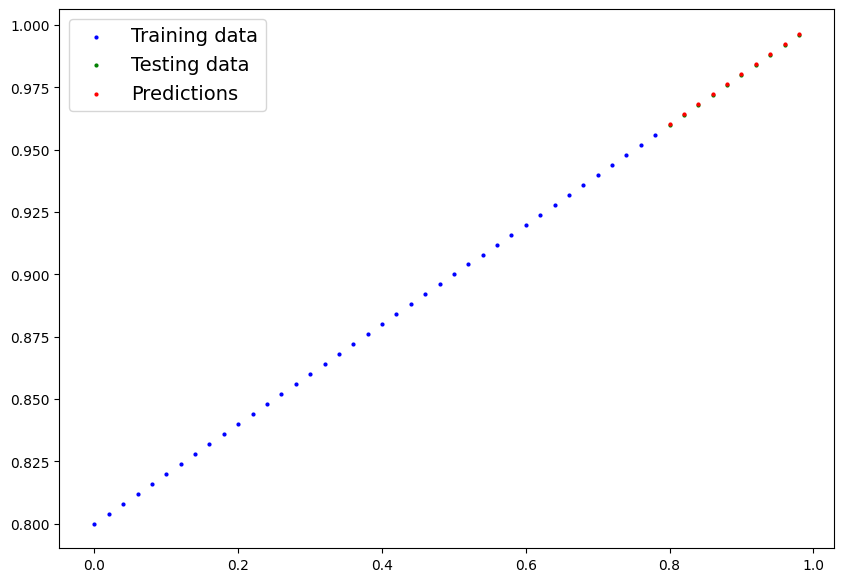

In [22]:
# visualization

plot_predictions(predictions=y_preds.cpu())

## Saving Model

In [23]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)

*

 

## Loading Model

In [24]:
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH, weights_only=True))

loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [25]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [27]:
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')